# Sumário

- Descrição do problema
 - Perguntas para serem respondidas utilizando a análise exploratória
- Configurações iniciais
 - Instalando Bibliotecas
 - Realização dos imports
 - Conectando ao google drive
 - Definição de caminhos para a base
- Análise exploratória
 - Definição de funções para a análise exploratória
 - Principais dúvidas do chat
 - Palavras que são mais escritas incorretamente
 - Gírias mais utilizadas pelos clientes
 - Pontuações mais frequentes nas perguntas
 - Bigramas mais frequentes nas respostas ao cliente
- Definição de funções de etapas de pré-processamento
 - Lendo base de dados
 - Definindo funções para o pré-processamento
- Uso de Pipeline de pré-processamento
 - Definição da Pipeline
 - Execução da pipeline
 - Exibição de resultados obtidos

# Descrição do problema

Atualmente, o Serviço de Atendimento ao Cliente (SAC) enfrenta uma alta demanda, com mais de 25 mil atendimentos mensais via chat online (Live Chat) em diversos idiomas. Esta carga de trabalho supera a capacidade de resposta dos atendentes humanos, resultando em atrasos no atendimento e insatisfação dos clientes.

Para enfrentar este desafio, será desenvolvido um chatbot baseado em modelos abertos de IA Generativa, destinado ao atendimento de clientes. Este chatbot será controlado por um grupo de usuários internos, permitindo a criação, operação e personalização contínua. Durante o projeto, um desenvolvedor da Brastel, no Brasil, será alocado para auxiliar no desenvolvimento, garantindo que os protótipos possam ser eficazmente utilizados na criação do sistema final completo.

### Perguntas para serem respondidas utilizando a análise exploratória

- Em qual período do dia o chat recebe mais acessos?
- Quais são as dúvidas mais perguntadas pelos usuários?
- Qual a proporção de palavras recorrentes escritas de maneira errada?
- As mensagens costumam ter muitas gírias ou abreviações?
- O uso de pontuação é algo comum nas mensagens?
- As respostas seguem algum padrão em alguma parte delas?

# Configurações Iniciais

## Instalando Bibliotecas

In [1]:
%%capture

!pip install spacy matplotlib spellchecker pandas

## Realização dos imports

In [2]:
import spacy
import re
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from spellchecker import SpellChecker
from collections import Counter
import matplotlib.pyplot as plt

## Conectando ao google drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

## Definição de caminhos para a base

In [4]:
DEFAULT_XLS_PATH = "/content/drive/MyDrive/m11/data/chat_clients.xlsx"
DEFAULT_CSV_PATH = "/content/drive/MyDrive/m11/data/data.csv"

def get_file_paths():
    xls_path = input(f"Digite o caminho do arquivo Excel (ou pressione Enter para usar o caminho padrão): ")
    xls_path = xls_path if xls_path.strip() else DEFAULT_XLS_PATH

    csv_path = input(f"Digite o caminho do arquivo CSV (ou pressione Enter para usar o caminho padrão): ")
    csv_path = csv_path if csv_path.strip() else DEFAULT_CSV_PATH

    return xls_path, csv_path

XLS_PATH, CSV_PATH = get_file_paths()

Nesta etapa, o colab é preparado com a instalação e importação de bibliotecas e pacotes necessários para a execução do projeto.

# Análise exploratória

## Definição de funções para a análise exploratória

In [5]:
nlp = spacy.load("pt_core_news_sm")
spell = SpellChecker(language='pt')

palavras_para_manter = {"bom", "boa", "ótimo", "excelente", "dia", "tarde", "noite"}

def remocao_stopword(text):
    doc = nlp(text)
    filtered_tokens = [
        token.text for token in doc 
        if not token.is_stop or token.text.lower() in palavras_para_manter
    ]
    return ' '.join(filtered_tokens)

def conversao_minuscula(text):
    return text.lower()

def limpar_sentenca(sentence: str) -> str:
    cleaned_sentence = re.sub(r'[^\w\s\'"áéíóúàèìòùâêîôûãõçÁÉÍÓÚÀÈÌÒÙÂÊÎÔÛÃÕÇ]', ' ', sentence)
    cleaned_sentence = re.sub(r'\s+', ' ', cleaned_sentence).strip()
    return cleaned_sentence

def verificar_giras_abreviacoes(texto, giras_abreviacoes):
    doc = nlp(texto)
    giras_encontradas = [token.text for token in doc if token.text.lower() in giras_abreviacoes]
    return giras_encontradas

def contar_pontuacoes(texto):
    doc = nlp(texto)
    pontuacoes = [token.text for token in doc if token.is_punct]
    return pontuacoes

def encontrar_bigramas(texto):
    doc = nlp(texto)
    tokens = [token.text for token in doc if not token.is_punct and not token.is_space]
    tokens = [token for token in tokens if token.isalpha()]
    bigramas = list(zip(tokens, tokens[1:]))
    frequencias = Counter(bigramas)
    return dict(frequencias)


In [6]:
df = pd.read_csv(CSV_PATH, sep=";")

df.dropna(axis=1, how="all", inplace=True)
df.dropna(axis=0, how="all", inplace=True)

df.rename(columns={'Resposta\n': 'Resposta'}, inplace=True)

raw_copy = df.copy()

print(df.shape)

df['Pergunta'] = df['Pergunta'].apply(remocao_stopword)
df['Pergunta'] = df['Pergunta'].apply(conversao_minuscula)
df['Intencao'] = df['Intencao'].apply(conversao_minuscula)
df['Pergunta'] = df['Pergunta'].apply(limpar_sentenca)
df['Resposta'] = df['Resposta'].apply(lambda x: conversao_minuscula(x) if isinstance(x, str) else '')

df

(505, 4)


,No,Intencao,Pergunta,Resposta
0,1.0,como depositar,boa dia tudo bem eu gostaria caixa family mart...,"bom dia! sim, o sr pode utilizar o cartão de d..."
1,2.0,como fazer remessa,enviar dinheiro japão,"para se inscrever no serviço de remessa, por f..."
2,3.0,tempo de remessa,levará beneficiário receber dinheiro,"via de regra, as remessas serão pagas via pix ..."
3,4.0,"pedido de envio via metodo ""byphone""",boa tarde acabei transferência 22 23 total 45y...,iremos processar a sua solicitacao.\nmuito obr...
4,5.0,"pedido de envio via metodo ""byphone""",poderia remessa 22yenes bbb rrr 23yenes aaaa m...,iremos processar a sua solicitacao.\nmuito obr...
...,...,...,...,...
500,501.0,atualizacao de dados cadastrais,boa tarde mudança endereço,a senhora pode trocar pelo próprio app da bras...
501,502.0,tempo de entrega do cartao,bom dia consegui depósito cartão chegou fiz pe...,boa noite\no sr solicitou dia 28. será entregu...
502,503.0,cancelamento,boa noite beneficiária avisou conta errado ped...,"sim, podemos cancelar\no valor voltará no seu ..."
503,504.0,reembolso,boa noite fiz depósito errado pra depositar co...,é possível solicitar o reembolso diretamente d...


## Principais dúvidas do chat

In [7]:
df_filtrado = df.copy()
df_filtrado

,No,Intencao,Pergunta,Resposta
0,1.0,como depositar,boa dia tudo bem eu gostaria caixa family mart...,"bom dia! sim, o sr pode utilizar o cartão de d..."
1,2.0,como fazer remessa,enviar dinheiro japão,"para se inscrever no serviço de remessa, por f..."
2,3.0,tempo de remessa,levará beneficiário receber dinheiro,"via de regra, as remessas serão pagas via pix ..."
3,4.0,"pedido de envio via metodo ""byphone""",boa tarde acabei transferência 22 23 total 45y...,iremos processar a sua solicitacao.\nmuito obr...
4,5.0,"pedido de envio via metodo ""byphone""",poderia remessa 22yenes bbb rrr 23yenes aaaa m...,iremos processar a sua solicitacao.\nmuito obr...
...,...,...,...,...
500,501.0,atualizacao de dados cadastrais,boa tarde mudança endereço,a senhora pode trocar pelo próprio app da bras...
501,502.0,tempo de entrega do cartao,bom dia consegui depósito cartão chegou fiz pe...,boa noite\no sr solicitou dia 28. será entregu...
502,503.0,cancelamento,boa noite beneficiária avisou conta errado ped...,"sim, podemos cancelar\no valor voltará no seu ..."
503,504.0,reembolso,boa noite fiz depósito errado pra depositar co...,é possível solicitar o reembolso diretamente d...


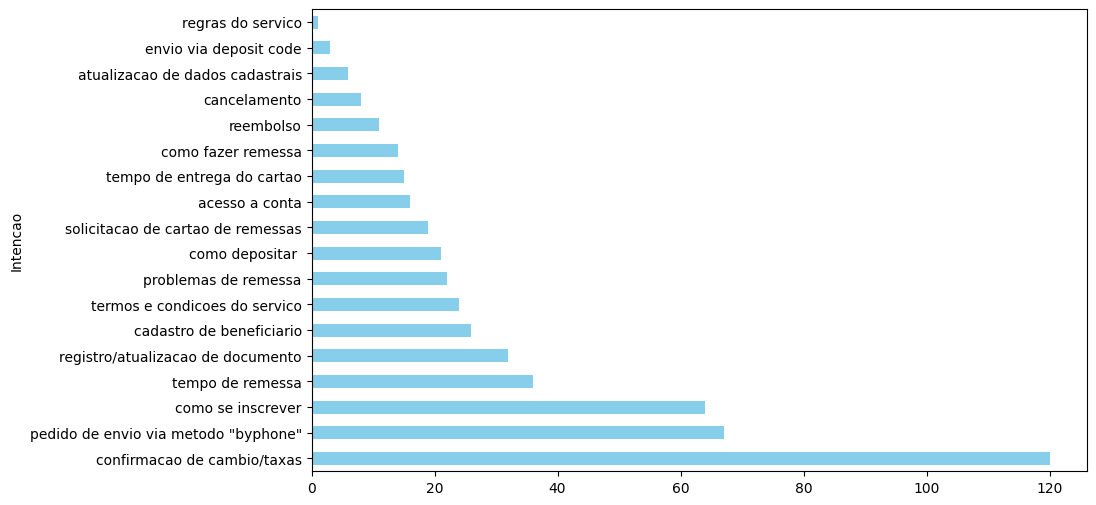

In [8]:
contagem = df_filtrado['Intencao'].value_counts()
plt.figure(figsize=(10, 6))
contagem.plot(kind='barh', color='skyblue')

plt.show()

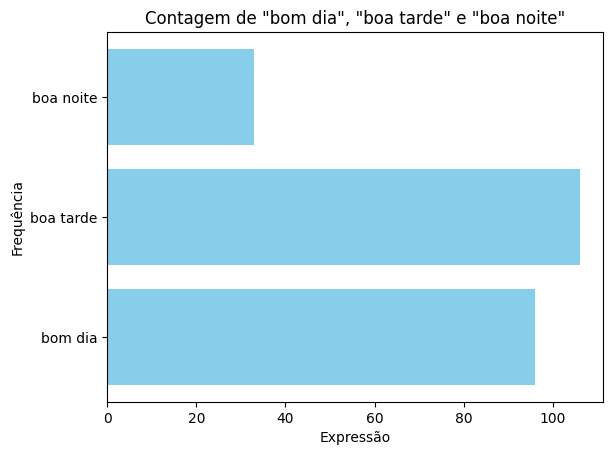

In [9]:
data = {
    'mensagens': [
        'bom dia',
        'boa tarde',
        'boa noite'
    ]
}

df_time = pd.DataFrame(data)

contagem = {
    'bom dia': df_filtrado['Pergunta'].str.contains('bom dia', case=False).sum(),
    'boa tarde': df_filtrado['Pergunta'].str.contains('boa tarde', case=False).sum(),
    'boa noite': df_filtrado['Pergunta'].str.contains('boa noite', case=False).sum()
}

plt.barh(list(contagem.keys()), list(contagem.values()), color=['skyblue'])
plt.xlabel('Expressão')
plt.ylabel('Frequência')
plt.title('Contagem de "bom dia", "boa tarde" e "boa noite"')
plt.show()

## Palavras que são mais escritas incorretamente

In [10]:
def preprocessar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r'[^\w\s]', '', texto)
    return texto

def encontrar_erros(texto):
    texto = preprocessar_texto(texto)
    doc = nlp(texto)
    palavras = [token.text for token in doc]
    erros = [palavra for palavra in palavras if palavra not in spell]
    
    return erros


(array([ 0., 10., 20., 30., 40., 50., 60., 70., 80.]),
 [Text(0.0, 0, '0'),
  Text(10.0, 0, '10'),
  Text(20.0, 0, '20'),
  Text(30.0, 0, '30'),
  Text(40.0, 0, '40'),
  Text(50.0, 0, '50'),
  Text(60.0, 0, '60'),
  Text(70.0, 0, '70'),
  Text(80.0, 0, '80')])

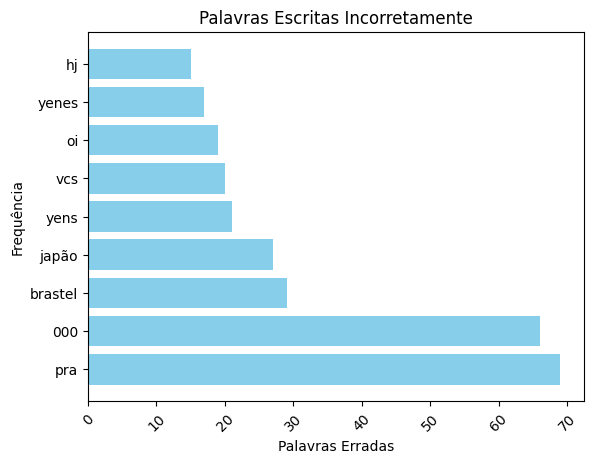

In [11]:
df_filtrado['erros'] = df_filtrado['Pergunta'].apply(lambda x: encontrar_erros(x))
todos_erros = [erro for sublist in df_filtrado['erros'] for erro in sublist]
contagem_erros = Counter(todos_erros)
top_erros = contagem_erros.most_common(10)[1:]
palavras, frequencias = zip(*top_erros)
plt.barh(list(palavras), list(frequencias), color='skyblue')
plt.xlabel('Palavras Erradas')
plt.ylabel('Frequência')
plt.title('Palavras Escritas Incorretamente')
plt.xticks(rotation=45)

## Gírias mais utilizadas pelos clientes

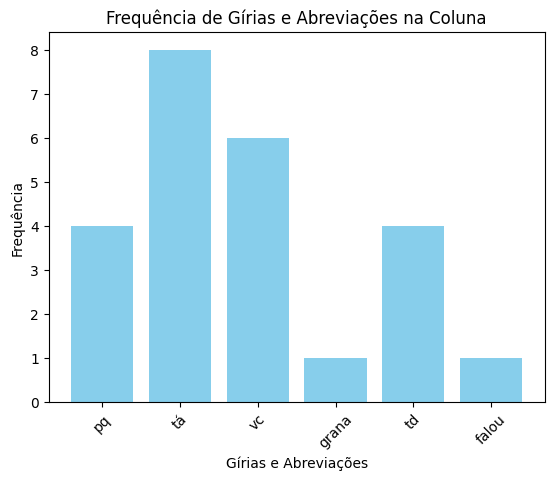

In [12]:
giras_abreviacoes = [
    "rolê", "zoar", "dahora", "massa", "mano", "man", "bicho", "treta", "falou",
    "sussa", "balada", "perifa", "bagulho", "cabuloso", "grana", "leco",
    "vc", "tb", "blz", "qnd", "pq", "ctz", "fds", "tbm", "mt", "flw", "n",
    "td", "tlg", "tá", "lol", "brb", "omg", "btw", "asap"
]

df_filtrado['giras_encontradas'] = df_filtrado['Pergunta'].apply(lambda x: verificar_giras_abreviacoes(x, giras_abreviacoes))

todos_giras = [giria for sublist in df_filtrado['giras_encontradas'] for giria in sublist]
contagem_giras = Counter(todos_giras)

plt.bar(contagem_giras.keys(), contagem_giras.values(), color='skyblue')
plt.xlabel('Gírias e Abreviações')
plt.ylabel('Frequência')
plt.title('Frequência de Gírias e Abreviações na Coluna')
plt.xticks(rotation=45)
plt.show()

## Pontuações mais frequentes nas perguntas

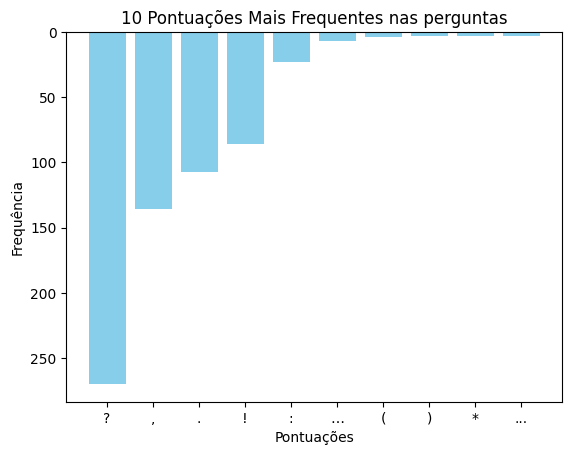

In [13]:
df_copy = raw_copy.copy() 

df_copy['pontuacoes'] = df_copy['Pergunta'].apply(contar_pontuacoes)

todas_pontuacoes = [ponto for sublist in df_copy['pontuacoes'] for ponto in sublist]
contagem_pontuacoes = Counter(todas_pontuacoes)

top_10_pontuacoes = contagem_pontuacoes.most_common(10)

pontuacoes, frequencias = zip(*top_10_pontuacoes)

plt.bar(pontuacoes, frequencias, color='skyblue')
plt.xlabel('Pontuações')
plt.ylabel('Frequência')
plt.title('10 Pontuações Mais Frequentes nas perguntas')
plt.gca().invert_yaxis()

plt.show()

## Bigramas mais frequentes nas respostas ao cliente

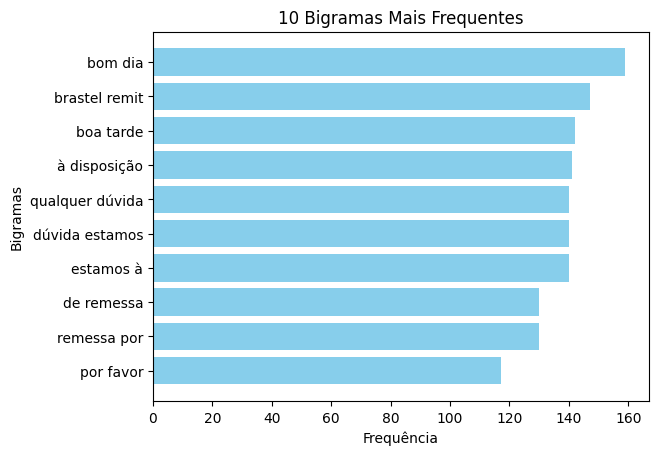

In [14]:
todos_bigramas = Counter()

for texto in df['Resposta']:
    try:
        bigramas = encontrar_bigramas(texto)
        todos_bigramas.update(bigramas)
    except Exception as e:
        print(f"Erro ao processar o texto: {e}")
        pass

top_10_bigramas = todos_bigramas.most_common(10)
bigramas, frequencias = zip(*top_10_bigramas)

bigramas = [' '.join(bigrama) for bigrama in bigramas]

plt.barh(bigramas, frequencias, color='skyblue')
plt.xlabel('Frequência')
plt.ylabel('Bigramas')
plt.title('10 Bigramas Mais Frequentes')
plt.gca().invert_yaxis()
plt.show()



# Definição de funções de etapas de pré-processamento

## lendo base de dados

In [15]:
copy = df.copy()

copy

,No,Intencao,Pergunta,Resposta
0,1.0,como depositar,boa dia tudo bem eu gostaria caixa family mart...,"bom dia! sim, o sr pode utilizar o cartão de d..."
1,2.0,como fazer remessa,enviar dinheiro japão,"para se inscrever no serviço de remessa, por f..."
2,3.0,tempo de remessa,levará beneficiário receber dinheiro,"via de regra, as remessas serão pagas via pix ..."
3,4.0,"pedido de envio via metodo ""byphone""",boa tarde acabei transferência 22 23 total 45y...,iremos processar a sua solicitacao.\nmuito obr...
4,5.0,"pedido de envio via metodo ""byphone""",poderia remessa 22yenes bbb rrr 23yenes aaaa m...,iremos processar a sua solicitacao.\nmuito obr...
...,...,...,...,...
500,501.0,atualizacao de dados cadastrais,boa tarde mudança endereço,a senhora pode trocar pelo próprio app da bras...
501,502.0,tempo de entrega do cartao,bom dia consegui depósito cartão chegou fiz pe...,boa noite\no sr solicitou dia 28. será entregu...
502,503.0,cancelamento,boa noite beneficiária avisou conta errado ped...,"sim, podemos cancelar\no valor voltará no seu ..."
503,504.0,reembolso,boa noite fiz depósito errado pra depositar co...,é possível solicitar o reembolso diretamente d...


In [16]:
print(copy.shape)
copy.head()

(505, 4)


,No,Intencao,Pergunta,Resposta
0,1.0,como depositar,boa dia tudo bem eu gostaria caixa family mart...,"bom dia! sim, o sr pode utilizar o cartão de d..."
1,2.0,como fazer remessa,enviar dinheiro japão,"para se inscrever no serviço de remessa, por f..."
2,3.0,tempo de remessa,levará beneficiário receber dinheiro,"via de regra, as remessas serão pagas via pix ..."
3,4.0,"pedido de envio via metodo ""byphone""",boa tarde acabei transferência 22 23 total 45y...,iremos processar a sua solicitacao.\nmuito obr...
4,5.0,"pedido de envio via metodo ""byphone""",poderia remessa 22yenes bbb rrr 23yenes aaaa m...,iremos processar a sua solicitacao.\nmuito obr...


## Definindo funções para o pré-processamento

In [17]:
def segmentar(texto):
    doc = nlp(texto)
    return [sent.text for sent in doc.sents]

def tokenizar(texto):
    doc = nlp(texto)
    return [token.text for token in doc]

def lematizar(tokens):
    doc = nlp(" ".join(tokens))
    return [token.lemma_ for token in doc]

def stemming(tokens):
    doc = nlp(" ".join(tokens))
    return [token.lemma_ for token in doc]

def remover_stopwords(tokens):
    doc = nlp(" ".join(tokens))
    return [token.text for token in doc if not token.is_stop]

def pos_tagging(tokens):
    doc = nlp(" ".join(tokens))
    return [(token.text, token.pos_) for token in doc]

def remover_pontuacao(tokens):
    doc = nlp(" ".join(tokens))
    return [token.text for token in doc if not token.is_punct]

def reconhecimento_entidades_nomeadas(tokens):
    if isinstance(tokens, list):
        texto = ' '.join(tokens)
    else:
        texto = tokens
    
    doc = nlp(texto)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities


## Testes das funções de pré-processamento

In [18]:
# Texto de exemplo
texto = "O Leandro comprou um carro novo. Ele está muito feliz com a nova aquisição!"

In [19]:
# Teste da função segmentar
resultado_esperado_segmentar = ['O Leandro comprou um carro novo.', 'Ele está muito feliz com a nova aquisição!']
resultado_obtido_segmentar = segmentar(texto)
assert resultado_obtido_segmentar == resultado_esperado_segmentar, f"Erro no teste de segmentação. Esperado: {resultado_esperado_segmentar}, Obtido: {resultado_obtido_segmentar}"
print("Teste de segmentação passou!")

Teste de segmentação passou!


In [20]:
# Teste da função tokenizar
resultado_esperado_tokenizar = ['O', 'Leandro', 'comprou', 'um', 'carro', 'novo', '.', 'Ele', 'está', 'muito', 'feliz', 'com', 'a', 'nova', 'aquisição', '!']
resultado_obtido_tokenizar = tokenizar(texto)
assert resultado_obtido_tokenizar == resultado_esperado_tokenizar, f"Erro no teste de tokenização. Esperado: {resultado_esperado_tokenizar}, Obtido: {resultado_obtido_tokenizar}"
print("Teste de tokenização passou!")

Teste de tokenização passou!


In [21]:
# Teste da função lematizar
tokens_exemplo = ['Leandro', 'comprou', 'carros']
resultado_esperado_lematizar = ['Leandro', 'comprar', 'carro']
resultado_obtido_lematizar = lematizar(tokens_exemplo)
assert resultado_obtido_lematizar == resultado_esperado_lematizar, f"Erro no teste de lematização. Esperado: {resultado_esperado_lematizar}, Obtido: {resultado_obtido_lematizar}"
print("Teste de lematização passou!")

Teste de lematização passou!


In [22]:
# Teste da função remover_stopwords
resultado_esperado_remover_stopwords = ['Leandro', 'comprou', 'carros']
resultado_obtido_remover_stopwords = remover_stopwords(tokens_exemplo)
assert resultado_obtido_remover_stopwords == resultado_esperado_remover_stopwords, f"Erro no teste de remoção de stopwords. Esperado: {resultado_esperado_remover_stopwords}, Obtido: {resultado_obtido_remover_stopwords}"
print("Teste de remoção de stopwords passou!")

Teste de remoção de stopwords passou!


In [23]:
# Teste da função pos_tagging
resultado_esperado_pos_tagging = [('Leandro', 'PROPN'), ('comprou', 'VERB'), ('carros', 'NOUN')]
resultado_obtido_pos_tagging = pos_tagging(tokens_exemplo)
assert resultado_obtido_pos_tagging == resultado_esperado_pos_tagging, f"Erro no teste de POS tagging. Esperado: {resultado_esperado_pos_tagging}, Obtido: {resultado_obtido_pos_tagging}"
print("Teste de POS tagging passou!")

Teste de POS tagging passou!


In [24]:
# Teste da função remover_pontuacao
tokens_com_pontuacao = ['Leandro', ',', 'comprou', 'carros', '.']
resultado_esperado_remover_pontuacao = ['Leandro', 'comprou', 'carros']
resultado_obtido_remover_pontuacao = remover_pontuacao(tokens_com_pontuacao)
assert resultado_obtido_remover_pontuacao == resultado_esperado_remover_pontuacao, f"Erro no teste de remoção de pontuação. Esperado: {resultado_esperado_remover_pontuacao}, Obtido: {resultado_obtido_remover_pontuacao}"
print("Teste de remoção de pontuação passou!")

Teste de remoção de pontuação passou!


In [25]:
# Teste da função reconhecimento_entidades_nomeadas
resultado_esperado_reconhecimento_entidades = [('Leandro', 'PER')]
resultado_obtido_reconhecimento_entidades = reconhecimento_entidades_nomeadas(tokens_exemplo)
assert resultado_obtido_reconhecimento_entidades == resultado_esperado_reconhecimento_entidades, f"Erro no teste de reconhecimento de entidades nomeadas. Esperado: {resultado_esperado_reconhecimento_entidades}, Obtido: {resultado_obtido_reconhecimento_entidades}"
print("Teste de reconhecimento de entidades nomeadas passou!")

Teste de reconhecimento de entidades nomeadas passou!


# Uso de Pipeline de pré-processamento

## Definição da Pipeline

In [26]:
import random
from collections import Counter

def pipeline_preprocessamento(texto, aplicar_segmentacao=True, aplicar_tokenizacao=True, aplicar_lematizacao=True,
                              aplicar_stemming=True, aplicar_remocao_stopwords=True, aplicar_pos_tagging=True,
                              aplicar_reconhecimento_entidades=True, aplicar_remocao_pontuacao=True):
    if aplicar_segmentacao:
        sentencas = segmentar(texto)
    else:
        sentencas = [texto]

    all_tokens = []

    for sentenca in sentencas:
        if aplicar_tokenizacao:
            tokens = tokenizar(sentenca)
            if aplicar_lematizacao:
                tokens = lematizar(tokens)
            if aplicar_remocao_pontuacao:
                tokens = remover_pontuacao(tokens)
            if aplicar_remocao_stopwords:
                tokens = remover_stopwords(tokens)
            if aplicar_stemming:
                tokens = stemming(tokens)
            all_tokens.extend(tokens)

    bow_counter = Counter(all_tokens)

    used_random_numbers = set()

    resultados = []
    for sentenca in sentencas:
        print(f"Processing sentence: {sentenca}")

        output = {'Sentenca Original': sentenca}

        if aplicar_tokenizacao:
            tokens = tokenizar(sentenca)
            print(f"Tokens: {tokens}")

        if aplicar_lematizacao:
            tokens = lematizar(tokens)
            print(f"Lemmatized Tokens: {tokens}")

        if aplicar_reconhecimento_entidades:
            entidades = reconhecimento_entidades_nomeadas(tokens)
            print(f"Named Entities: {entidades}")
            named_entity_tokens = {entity[0] for entity in entidades}
        else:
            named_entity_tokens = set()

        if aplicar_remocao_pontuacao:
            tokens = remover_pontuacao(tokens)
            print(f"Tokens after Punctuation Removal: {tokens}")

        if aplicar_remocao_stopwords:
            tokens = remover_stopwords(tokens)
            print(f"Tokens after Stopword Removal: {tokens}")

        if aplicar_pos_tagging:
            pos_tags = pos_tagging(tokens)
            print(f"POS Tags: {pos_tags}")
            pos_tag_dict = {word: tag for word, tag in pos_tags}
        else:
            pos_tag_dict = {}

        if aplicar_stemming:
            stemmed_tokens = stemming(tokens)
            print(f"Stemmed Tokens: {stemmed_tokens}")

        sentence_counter = Counter(tokens)

        seen_tokens = set()
        combined_info = []
        for stem, token in zip(stemmed_tokens, tokens):
            if token not in seen_tokens:
                seen_tokens.add(token)
                is_named = True if token in named_entity_tokens else False
                pos = pos_tag_dict.get(token, "None")
                sentence_count = sentence_counter[token]

                random_number = random.randint(1, 1000)
                while random_number in used_random_numbers:
                    random_number = random.randint(1, 1000)
                used_random_numbers.add(random_number)

                combined_info.append([stem, is_named, pos, sentence_count, random_number])

        output['words'] = combined_info
        resultados.append(output)

        print("________________________________________________________")

    return resultados

## Execução da pipeline

In [27]:
frase_teste = "O presidente da França, Emmanuel Macron, visitou Lisboa na semana passada. Ele discutiu sobre a economia e a cultura local. Emmanuel Emmanuel é zika."

resultados = pipeline_preprocessamento(frase_teste)

df_resultados = pd.DataFrame(resultados)

display(df_resultados)

Processing sentence: O presidente da França, Emmanuel Macron, visitou Lisboa na semana passada.
Tokens: ['O', 'presidente', 'da', 'França', ',', 'Emmanuel', 'Macron', ',', 'visitou', 'Lisboa', 'na', 'semana', 'passada', '.']
Lemmatized Tokens: ['o', 'presidente', 'de o', 'França', ',', 'Emmanuel', 'Macron', ',', 'visitar', 'Lisboa', 'em o', 'semana', 'passado', '.']
Named Entities: [('França', 'LOC'), ('Emmanuel Macron', 'PER'), ('Lisboa', 'LOC')]
Tokens after Punctuation Removal: ['o', 'presidente', 'de', 'o', 'França', 'Emmanuel', 'Macron', 'visitar', 'Lisboa', 'em', 'o', 'semana', 'passado']
Tokens after Stopword Removal: ['presidente', 'França', 'Emmanuel', 'Macron', 'visitar', 'Lisboa', 'semana', 'passado']
POS Tags: [('presidente', 'NOUN'), ('França', 'PROPN'), ('Emmanuel', 'PROPN'), ('Macron', 'PROPN'), ('visitar', 'VERB'), ('Lisboa', 'PROPN'), ('semana', 'NOUN'), ('passado', 'ADJ')]
Stemmed Tokens: ['presidente', 'França', 'Emmanuel', 'Macron', 'visitar', 'Lisboa', 'semana', 'p

,Sentenca Original,words
0,"O presidente da França, Emmanuel Macron, visit...","[[presidente, False, NOUN, 1, 658], [França, T..."
1,Ele discutiu sobre a economia e a cultura local.,"[[discutir, False, VERB, 1, 527], [economia, F..."
2,Emmanuel Emmanuel é zika.,"[[Emmanuel, False, PROPN, 2, 916], [zika, Fals..."


## Exibição de resultados obtidos

In [28]:
print(resultados)

[{'Sentenca Original': 'O presidente da França, Emmanuel Macron, visitou Lisboa na semana passada.', 'words': [['presidente', False, 'NOUN', 1, 658], ['França', True, 'PROPN', 1, 896], ['Emmanuel', False, 'PROPN', 1, 272], ['Macron', False, 'PROPN', 1, 980], ['visitar', False, 'VERB', 1, 868], ['Lisboa', True, 'PROPN', 1, 72], ['semana', False, 'NOUN', 1, 275], ['passado', False, 'ADJ', 1, 793]]}, {'Sentenca Original': 'Ele discutiu sobre a economia e a cultura local.', 'words': [['discutir', False, 'VERB', 1, 527], ['economia', False, 'NOUN', 1, 209], ['culturo', False, 'ADJ', 1, 80]]}, {'Sentenca Original': 'Emmanuel Emmanuel é zika.', 'words': [['Emmanuel', False, 'PROPN', 2, 916], ['zika', False, 'PROPN', 1, 604]]}]


In [29]:
for resultado in resultados:
    print(f"Sentence: {resultado['Sentenca Original']}")
    print("Words:")
    for word_info in resultado['words']:
        print(word_info)
    print("________________________________________________________")

Sentence: O presidente da França, Emmanuel Macron, visitou Lisboa na semana passada.
Words:
['presidente', False, 'NOUN', 1, 658]
['França', True, 'PROPN', 1, 896]
['Emmanuel', False, 'PROPN', 1, 272]
['Macron', False, 'PROPN', 1, 980]
['visitar', False, 'VERB', 1, 868]
['Lisboa', True, 'PROPN', 1, 72]
['semana', False, 'NOUN', 1, 275]
['passado', False, 'ADJ', 1, 793]
________________________________________________________
Sentence: Ele discutiu sobre a economia e a cultura local.
Words:
['discutir', False, 'VERB', 1, 527]
['economia', False, 'NOUN', 1, 209]
['culturo', False, 'ADJ', 1, 80]
________________________________________________________
Sentence: Emmanuel Emmanuel é zika.
Words:
['Emmanuel', False, 'PROPN', 2, 916]
['zika', False, 'PROPN', 1, 604]
________________________________________________________


In [30]:
def validate_word_info(word_info):
    """
    Valida o formato de um array de informações da palavra.

    :param word_info: Array com informações da palavra a ser validado.
    :return: True se o array estiver no formato esperado, False caso contrário.
    """
    if len(word_info) != 5:
        print(f"Array com comprimento inválido: {word_info}")
        return False

    if not isinstance(word_info[0], str):
        print(f"Primeiro elemento não é uma string: {word_info}")
        return False

    if not isinstance(word_info[1], bool):
        print(f"Segundo elemento não é um booleano: {word_info}")
        return False

    if not (word_info[2] is None or isinstance(word_info[2], str)):
        print(f"Terceiro elemento não é uma string ou None: {word_info}")
        return False

    if not isinstance(word_info[3], int):
        print(f"Quarto elemento não é um inteiro: {word_info}")
        return False

    if not isinstance(word_info[4], int):
        print(f"Quinto elemento não é um inteiro: {word_info}")
        return False

    return True

def validate_results(resultados):
    """
    Função para validar todos os arrays de informações das palavras em uma lista de resultados.

    :param resultados: Lista de dicionários contendo a chave 'words' com arrays a serem validados.
    :return: True se todos os arrays estiverem no formato esperado, False caso contrário.
    """
    all_valid = True

    for resultado in resultados:
        print(f"Sentence: {resultado['Sentenca Original']}")
        print("Words:")
        for word_info in resultado['words']:
            if not validate_word_info(word_info):
                all_valid = False
            print(word_info)
        print("________________________________________________________")

    return all_valid

is_valid = validate_results(resultados)
print(f"Os arrays são válidos? {is_valid}")


Sentence: O presidente da França, Emmanuel Macron, visitou Lisboa na semana passada.
Words:
['presidente', False, 'NOUN', 1, 658]
['França', True, 'PROPN', 1, 896]
['Emmanuel', False, 'PROPN', 1, 272]
['Macron', False, 'PROPN', 1, 980]
['visitar', False, 'VERB', 1, 868]
['Lisboa', True, 'PROPN', 1, 72]
['semana', False, 'NOUN', 1, 275]
['passado', False, 'ADJ', 1, 793]
________________________________________________________
Sentence: Ele discutiu sobre a economia e a cultura local.
Words:
['discutir', False, 'VERB', 1, 527]
['economia', False, 'NOUN', 1, 209]
['culturo', False, 'ADJ', 1, 80]
________________________________________________________
Sentence: Emmanuel Emmanuel é zika.
Words:
['Emmanuel', False, 'PROPN', 2, 916]
['zika', False, 'PROPN', 1, 604]
________________________________________________________
Os arrays são válidos? True
